In [8]:
import pandas as pd

# Đọc file và chuyển đổi event_time sang datetime
df = pd.read_csv("events_processed.csv", parse_dates=['event_time'])

# Hiển thị 5 dòng đầu tiên
print(df.head())


C:\Users\PC\AppData\Local\Temp\ipykernel_1572\1393263718.py:4: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("events_processed.csv", parse_dates=['event_time'])


                 event_time event_type  product_id          category_id  \
0 2020-09-24 11:57:06+00:00       view     1996170  2144415922528452715   
1 2020-09-24 11:57:26+00:00       view      139905  2144415926932472027   
2 2020-09-24 11:57:27+00:00       view      215454  2144415927158964449   
3 2020-09-24 11:57:33+00:00       view      635807  2144415923107266682   
4 2020-09-24 11:57:36+00:00       view     3658723  2144415921169498184   

                   category_code        brand   price              user_id  \
0          electronics.telephone      unknown   31.90  1515915625519388267   
1    computers.components.cooler       zalman   17.16  1515915625519380411   
2                        unknown      unknown    9.81  1515915625513238515   
3  computers.peripherals.printer       pantum  113.81  1515915625519014356   
4                        unknown  cameronsino   15.87  1515915625510743344   

  user_session  year  month  day  quarter  week  weekday  dayofyear  \
0   LJuJV

In [9]:
# Tần suất từng loại event
event_counts = df['event_type'].value_counts()
print("\n📈 Event type distribution:\n", event_counts)

# Tỷ lệ phần trăm
print("\n📊 Percentage:\n", (event_counts / len(df) * 100).round(2))



📈 Event type distribution:
 event_type
view        793589
cart         54029
purchase     37346
Name: count, dtype: int64

📊 Percentage:
 event_type
view        89.67
cart         6.11
purchase     4.22
Name: count, dtype: float64


### 🎯 Mô hình Phân cụm (Clustering Model) – Phân loại khách hàng

#### 1. Mục tiêu của mô hình
Mô hình phân cụm nhằm chia tập khách hàng thành các nhóm có hành vi tương đồng, từ đó giúp doanh nghiệp:
- Hiểu rõ đặc điểm từng nhóm khách hàng
- Thiết kế chiến dịch marketing cá nhân hoá
- Tăng hiệu quả chăm sóc, giữ chân khách hàng
- Dự đoán rủi ro rời bỏ (churn) và tối ưu chuyển đổi (conversion)

---

#### 2. Phương pháp sử dụng: K-Means Clustering

**K-Means** là thuật toán phân cụm phổ biến nhất, hoạt động theo nguyên tắc:
1. Chọn số cụm K.
2. Gán mỗi điểm dữ liệu vào cụm gần nhất (dựa trên khoảng cách Euclidean).
3. Cập nhật tâm cụm → lặp lại đến khi hội tụ.

Thuật toán tìm cách **giảm tổng khoảng cách từ các điểm đến tâm cụm** – giúp các cụm nội bộ đồng nhất nhất có thể.

---

#### 3. Các đặc trưng được sử dụng trong phân cụm

Để đảm bảo mô hình nắm bắt được **toàn bộ hành vi mua sắm của khách hàng**, chúng tôi lựa chọn kết hợp 3 nhóm đặc trưng sau:

| Nhóm | Biến | Giải thích |
|------|------|------------|
| **RFM** | Recency | Số ngày kể từ lần mua cuối cùng |
|        | Frequency | Số lần mua hàng |
|        | Monetary | Tổng số tiền đã chi tiêu |
| **Chuyển đổi** | Conversion Rate | Tỷ lệ mua hàng trên số lượt xem |
| **Từ bỏ giỏ** | Cart Abandonment Rate | Tỷ lệ bỏ giỏ hàng sau khi thêm vào |



In [10]:
# Tính đặc trưng RFM

# Ngày tham chiếu (mốc cuối cùng trong dữ liệu)
reference_date = df["event_time"].max()

# Lọc các hành vi
df_purchase = df.query("event_type == 'purchase'")
df_view = df.query("event_type == 'view'")
df_cart = df.query("event_type == 'cart'")

# Recency – số ngày từ lần mua gần nhất
recency = (
    df_purchase.groupby("user_id")["event_time"]
    .max()
    .apply(lambda x: (reference_date - x).days)
    .reset_index()
    .rename(columns={"event_time": "Recency"})
)

# Frequency – số phiên mua hàng duy nhất (user_id + session)
frequency = (
    df_purchase.drop_duplicates(subset=["user_id", "user_session"])
    .groupby("user_id")
    .size()
    .reset_index(name="Frequency")
)

# Monetary – tổng chi tiêu
monetary = (
    df_purchase.groupby("user_id")["price"]
    .sum()
    .reset_index()
    .rename(columns={"price": "Monetary"})
)

In [11]:
# Tính Conversion Rate theo phiên (session-level)

# Đếm số phiên có lượt xem
view_sessions = (
    df_view.drop_duplicates(subset=["user_id", "user_session"])
    .groupby("user_id")
    .size()
    .reset_index(name="ViewSessions")
)

# Đếm số phiên có mua hàng
purchase_sessions = (
    df_purchase.drop_duplicates(subset=["user_id", "user_session"])
    .groupby("user_id")
    .size()
    .reset_index(name="PurchaseSessions")
)

# Tính Conversion Rate = số phiên có mua / số phiên có view
conversion = pd.merge(view_sessions, purchase_sessions, on="user_id", how="left").fillna(0)
conversion["ConversionRate"] = conversion["PurchaseSessions"] / conversion["ViewSessions"]
conversion = conversion[["user_id", "ConversionRate"]]


In [12]:
# Tính Cart Abandonment Rate theo phiên

# Bước 1: Đếm số phiên có hành vi thêm giỏ (cart)
cart_sessions = (
    df_cart.drop_duplicates(subset=["user_id", "user_session"])
    .groupby("user_id")
    .size()
    .reset_index(name="CartSessions")
)

# Bước 2: Đếm số phiên có hành vi mua hàng (purchase)
purchase_sessions = (
    df_purchase.drop_duplicates(subset=["user_id", "user_session"])
    .groupby("user_id")
    .size()
    .reset_index(name="PurchaseSessions")
)

# Bước 3: Tính tỷ lệ bỏ giỏ hàng
cart_abandon = pd.merge(cart_sessions, purchase_sessions, on="user_id", how="left").fillna(0)
cart_abandon["CartAbandonmentRate"] = (
    (cart_abandon["CartSessions"] - cart_abandon["PurchaseSessions"]) / cart_abandon["CartSessions"]
)
cart_abandon = cart_abandon[["user_id", "CartAbandonmentRate"]]


In [16]:
# ⚠️ Xử lý các trường hợp âm hoặc -inf
cart_abandon["CartAbandonmentRate"] = cart_abandon["CartAbandonmentRate"].clip(lower=0)
cart_abandon = cart_abandon[["user_id", "CartAbandonmentRate"]]

dfs = [recency, frequency, monetary, conversion, cart_abandon]
df_user_features = dfs[0]
for d in dfs[1:]:
    df_user_features = pd.merge(df_user_features, d, on="user_id", how="outer")

# Bỏ các user thiếu thông tin chính (RFM)
df_user_features.dropna(subset=["Recency", "Frequency", "Monetary"], inplace=True)

# Fill NaN cho Conversion và Abandon
df_user_features.fillna({
    "ConversionRate": 0,
    "CartAbandonmentRate": 0
}, inplace=True)

# Xem trước kết quả
df_user_features.head(10)

,user_id,Recency,Frequency,Monetary,ConversionRate,CartAbandonmentRate
9,1515915625353286099,148.0,1.0,119.03,0.142857,0.500000
17,1515915625353457259,152.0,1.0,55.16,1.000000,0.000000
29,1515915625353534622,145.0,1.0,57.15,1.000000,0.000000
35,1515915625353561691,95.0,1.0,345.72,0.500000,0.000000
54,1515915625353900095,136.0,1.0,57.85,0.500000,0.500000
79,1515915625354176736,152.0,1.0,236.97,0.500000,0.500000
94,1515915625354561351,149.0,2.0,155.04,0.400000,0.333333
103,1515915625354822642,97.0,1.0,120.27,0.333333,0.000000
104,1515915625354857951,101.0,1.0,210.28,0.333333,0.500000
116,1515915625355179497,116.0,2.0,271.59,1.000000,0.000000


In [18]:
from sklearn.preprocessing import StandardScaler
# === CHUẨN HÓA ===
features = ["Recency", "Frequency", "Monetary", "ConversionRate", "CartAbandonmentRate"]
X = df_user_features[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=features, index=df_user_features.index)

# ✅ Sẵn sàng cho bước tiếp theo: chọn K, phân cụm, v.v.
print(df_scaled.head())

     Recency  Frequency  Monetary  ConversionRate  CartAbandonmentRate
9   1.651011  -0.320771 -0.285546       -1.833112             3.873164
17  1.739715  -0.320771 -0.435585        0.562449            -0.251518
29  1.584483  -0.320771 -0.430910        0.562449            -0.251518
35  0.475682  -0.320771  0.246979       -0.834962            -0.251518
54  1.384899  -0.320771 -0.429266       -0.834962             3.873164


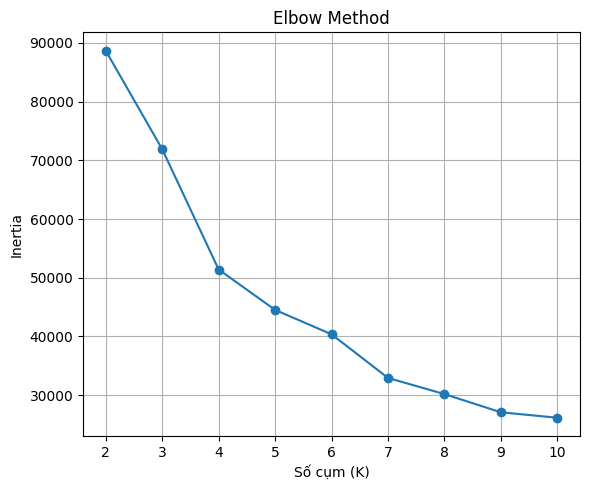

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Đặt tập dữ liệu đã chuẩn hóa: df_scaled
X_scaled = df_scaled.copy()

# Phạm vi K thử nghiệm
K_range = range(2, 11)

# Lưu kết quả Inertia (tổng khoảng cách nội cụm)
inertias = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Vẽ biểu đồ Elbow
plt.figure(figsize=(6, 5))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("Số cụm (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()


### 📊 Nhận xét từ biểu đồ Elbow Method

Biểu đồ trên thể hiện mối quan hệ giữa **số cụm (K)** và **Inertia** – tổng bình phương khoảng cách từ các điểm đến tâm cụm.

#### 📌 Các quan sát chính:

- Khi tăng K từ 2 → 4, **Inertia giảm mạnh**, cho thấy mô hình phân cụm hiệu quả hơn rõ rệt.
- Từ **K = 4 đến K = 6**, độ dốc vẫn còn nhưng bắt đầu **chậm lại**.
- Từ **K ≥ 7**, đường cong **gần như phẳng** → tăng K không giúp giảm Inertia đáng kể nữa.

#### 📍 Đề xuất số cụm:

- **Điểm “gãy khuỷu tay” (elbow)** rõ ràng xuất hiện tại **K = 4**
- Đây là điểm tối ưu để cân bằng giữa:
  - Độ chính xác phân cụm
  - Độ đơn giản mô hình
  - Tính dễ hiểu khi phân tích hành vi khách hàng

✅ **Do đó, chọn K = 4 là hợp lý** cho mô hình phân cụm khách hàng.



In [21]:
from sklearn.cluster import KMeans

# Huấn luyện mô hình KMeans với K = 4
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
df_user_features["cluster"] = kmeans.fit_predict(df_scaled)

# Xem trước kết quả
df_user_features[["user_id", "cluster"] + features].head()


,user_id,cluster,Recency,Frequency,Monetary,ConversionRate,CartAbandonmentRate
9,1515915625353286099,3,148.0,1.0,119.03,0.142857,0.5
17,1515915625353457259,0,152.0,1.0,55.16,1.000000,0.0
29,1515915625353534622,0,145.0,1.0,57.15,1.000000,0.0
35,1515915625353561691,0,95.0,1.0,345.72,0.500000,0.0
54,1515915625353900095,3,136.0,1.0,57.85,0.500000,0.5


c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


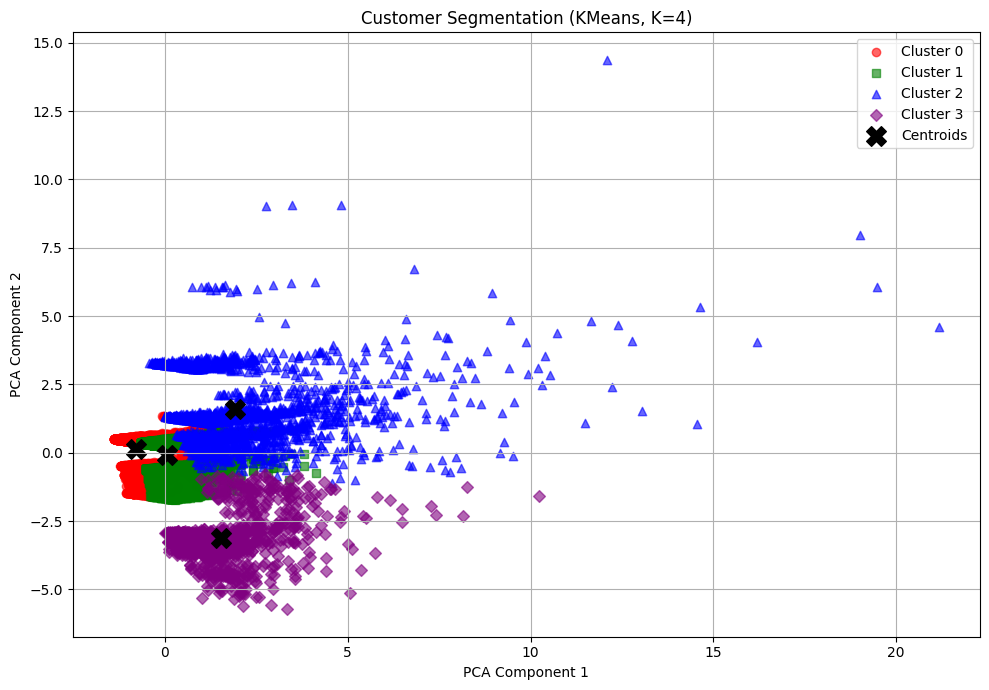

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Áp dụng PCA để giảm chiều dữ liệu đã chuẩn hóa
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

# Gán PCA vào DataFrame
df_user_features["PCA1"] = X_pca[:, 0]
df_user_features["PCA2"] = X_pca[:, 1]

# Giảm chiều tâm cụm (centroids) để vẽ
centers_pca = pca.transform(kmeans.cluster_centers_)

# Cấu hình marker và màu cho các cụm
colors = ['red', 'green', 'blue', 'purple']
markers = ['o', 's', '^', 'D']  # tròn, vuông, tam giác, kim cương

# Tạo biểu đồ
plt.figure(figsize=(10, 7))

# Vẽ từng cụm
for i in range(4):  # Vì K = 4
    subset = df_user_features[df_user_features["cluster"] == i]
    plt.scatter(
        subset["PCA1"],
        subset["PCA2"],
        c=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        label=f"Cluster {i}",
        alpha=0.6
    )

# Vẽ tâm cụm
plt.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    c='black',
    s=200,
    marker='X',
    label='Centroids'
)

# Trang trí
plt.title("Customer Segmentation (KMeans, K=4)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [29]:
# Tính trung bình các đặc trưng theo từng cụm
cluster_profile = (
    df_user_features.groupby("cluster")[["Recency", "Frequency", "Monetary", "ConversionRate", "CartAbandonmentRate"]]
    .mean()
    .round(2)
    .reset_index()
)

# Đếm số lượng khách hàng mỗi cụm
cluster_counts = df_user_features["cluster"].value_counts().sort_index().reset_index()
cluster_counts.columns = ["cluster", "num_customers"]

# Gộp lại với bảng trung bình
cluster_profile = pd.merge(cluster_profile, cluster_counts, on="cluster")

# Xem kết quả
cluster_profile

,cluster,Recency,Frequency,Monetary,ConversionRate,CartAbandonmentRate,num_customers
0,0,115.86,1.01,121.76,0.82,0.00,8650
1,1,36.50,1.00,232.00,0.77,0.00,9095
2,2,65.39,2.21,657.46,1.05,0.01,2305
3,3,65.45,1.16,356.19,0.37,0.50,1254


### 🏷️ Gán nhãn cho các cụm khách hàng

Dựa vào đặc trưng trung bình của từng cụm:

- **Cluster 0** – `Recency cao`, `Frequency thấp`, `Monetary thấp`  
  → **Nhóm khách không còn tương tác** → Gọi là **"Churned"**

- **Cluster 1** – `Recency thấp`, `Frequency thấp`, `Monetary trung bình`  
  → **Khách mới vừa mua lần đầu** → Gọi là **"New Buyer"**

- **Cluster 2** – `Frequency cao`, `Monetary rất cao`, `Conversion cao`  
  → **Khách hàng trung thành, chi tiêu cao** → Gọi là **"VIP"**

- **Cluster 3** – `Conversion thấp`, `Cart Abandonment cao`  
  → **Khách thêm giỏ nhưng không mua** → Gọi là **"Cart Abandoner"**
